# `dtreeviz` XGBoost Examples

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use XGBoost and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [61]:
import sys
import os
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [62]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q xgboost==1.5.0

In [63]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np

random_state = 1234 # get reproducible trees

## Load Sample Data

In [64]:
dataset_url = "https://raw.githubusercontent.com/datajour-gr/iqjournalism/main/sample_data/dataML_quality.csv"
dataset = pd.read_csv(dataset_url)

In [65]:
dataset.anger.describe()

count    44656.000000
mean         0.817377
std          1.094732
min          0.000000
25%          0.000000
50%          0.491602
75%          1.265823
max         15.662651
Name: anger, dtype: float64

In [66]:
dataset = dataset.dropna()
dataset.shape

(44470, 37)

In [67]:
dataset.head(4)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,...,Sadness_intensity,Fear_intensity,No Celebs,animal,crime,caps_body,numbers,urls,special_char_ratio,quality
0,0.980392,2.941176,0.00000,0.00000,0.980392,0.980392,0.980392,0.980392,0.00000,0.000000,...,0.059000,0.099625,0,0,0,0,2,0,2.941176,1
1,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.133000,0,0,0,0,2,0,6.060606,1
2,0.000000,0.000000,0.00000,0.00000,0.000000,1.538462,0.000000,0.000000,0.00000,3.076923,...,0.074846,0.059154,0,0,0,0,1,0,3.076923,1
3,0.000000,1.971831,0.28169,0.56338,0.563380,1.126761,3.098592,0.281690,0.28169,0.845070,...,0.098161,0.085952,0,0,0,0,0,0,2.535211,1


In [68]:
dataset.columns

Index(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust', 'valence', 'arousal',
       'dominance', 'strongsubj', ' weaksubj', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'mean_word_length', 'n_stop_words', 'sources',
       'length', 'MTLD', 'Nouns', 'Verbs', 'Adjectives', 'Anger_intensity',
       'Joy_intensity', 'Sadness_intensity', 'Fear_intensity', 'No Celebs',
       'animal', 'crime', 'caps_body', 'numbers', 'urls', 'special_char_ratio',
       'quality'],
      dtype='object')

In [69]:
dataset = dataset[[ 'anger', 
                   'anticipation', 'disgust', #'fear', 'joy', 
    'negative','positive', #'sadness', 
    'surprise', 'trust', 'valence', 'arousal',
       'dominance', 'strongsubj', #' weaksubj', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'mean_word_length', #'n_stop_words', 
            'sources',
       'length', #'MTLD', 'Nouns', 'Verbs', 
            'Adjectives', 
'Anger_intensity','Joy_intensity', 'Sadness_intensity', 'Fear_intensity', 
            'No Celebs','animal', 'crime', 'caps_body','quality'] 
        ].copy()

In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44470 entries, 0 to 44655
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anger                 44470 non-null  float64
 1   anticipation          44470 non-null  float64
 2   disgust               44470 non-null  float64
 3   negative              44470 non-null  float64
 4   positive              44470 non-null  float64
 5   surprise              44470 non-null  float64
 6   trust                 44470 non-null  float64
 7   valence               44470 non-null  float64
 8   arousal               44470 non-null  float64
 9   dominance             44470 non-null  float64
 10  strongsubj            44470 non-null  float64
 11  flesch_kincaid_grade  44470 non-null  float64
 12  mean_word_length      44470 non-null  float64
 13  sources               44470 non-null  int64  
 14  length                44470 non-null  int64  
 15  Adjectives            44

# Classifiers

To demonstrate classifier decision trees, we trying to model using six features to predict the boolean survived target.

In [71]:
from sklearn.model_selection import train_test_split

predictors = dataset.drop("quality",axis=1)
target = dataset["quality"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [72]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
xgb_model.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_test, Y_test)])

Y_pred_xgb = xgb_model.predict(X_test)

[0]	validation_0-auc:0.77878
[1]	validation_0-auc:0.78936
[2]	validation_0-auc:0.79427
[3]	validation_0-auc:0.79540
[4]	validation_0-auc:0.79923
[5]	validation_0-auc:0.80168
[6]	validation_0-auc:0.80555
[7]	validation_0-auc:0.80735
[8]	validation_0-auc:0.80835
[9]	validation_0-auc:0.80884
[10]	validation_0-auc:0.81019
[11]	validation_0-auc:0.81061
[12]	validation_0-auc:0.81139
[13]	validation_0-auc:0.81208
[14]	validation_0-auc:0.81247
[15]	validation_0-auc:0.81280
[16]	validation_0-auc:0.81278
[17]	validation_0-auc:0.81244
[18]	validation_0-auc:0.81263
[19]	validation_0-auc:0.81325
[20]	validation_0-auc:0.81315
[21]	validation_0-auc:0.81321
[22]	validation_0-auc:0.81367
[23]	validation_0-auc:0.81388
[24]	validation_0-auc:0.81500
[25]	validation_0-auc:0.81532
[26]	validation_0-auc:0.81532
[27]	validation_0-auc:0.81572
[28]	validation_0-auc:0.81547
[29]	validation_0-auc:0.81646


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[30]	validation_0-auc:0.81655
[31]	validation_0-auc:0.81681
[32]	validation_0-auc:0.81725
[33]	validation_0-auc:0.81699
[34]	validation_0-auc:0.81683
[35]	validation_0-auc:0.81686
[36]	validation_0-auc:0.81708
[37]	validation_0-auc:0.81710


In [73]:
print("best score: {0}, best iteration: {1}".format(xgb_model.best_score, xgb_model.best_iteration))

best score: 0.8172505797544414, best iteration: 32


In [74]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
f1_score(Y_test, Y_pred_xgb, average='weighted')

0.7300897621142513

In [75]:
features = ['anger', 
                   'anticipation', 'disgust', #'fear', 'joy', 
    'negative','positive', #'sadness', 
    'surprise', 'trust', 'valence', 'arousal',
       'dominance', 'strongsubj', #' weaksubj', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'mean_word_length', #'n_stop_words', 
            'sources',
       'length', #'MTLD', 'Nouns', 'Verbs', 
            'Adjectives', 
'Anger_intensity','Joy_intensity', 'Sadness_intensity', 'Fear_intensity', 
            'No Celebs','animal', 'crime', 'caps_body'
           ]
target = "quality"

In [76]:
dtrain = xgb.DMatrix(dataset[features], dataset[target])

params = {"max_depth":1, "eta":0.05, "objective":"binary:logistic", "subsample":1}
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

In [77]:
X_train,X_test,Y_train,Y_test = train_test_split(dataset[features],dataset["quality"],test_size=0.20,random_state=0)

In [78]:
#CM

In [79]:
xgb_model = xgb.XGBClassifier(max_depth=4,  n_estimators = 80, objective= "binary:logistic",  random_state=42, eval_metric="auc")

xgb_model.fit(X_train, Y_train)#, early_stopping_rounds=5, eval_set=[(X_test, Y_test)])

Y_pred_xgb = xgb_model.predict(X_test)

In [80]:
score_xgb = round(accuracy_score(Y_pred_xgb,Y_test)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")

The accuracy score achieved using XGBoost is: 73.76 %


In [81]:
f1_score(Y_test, Y_pred_xgb, average='weighted')

0.7329386824063144

In [82]:
#print("best score: {0}, best iteration: {1}".format(xgb_model.best_score, xgb_model.best_iteration))

## Initialize dtreeviz model (adaptor)

To adapt dtreeviz to a specific model, use the `model()` function to get an adaptor.  You'll need to provide the model, X/y data, feature names, target name, and target class names:

In [83]:
viz_model = dtreeviz.model(xgb_model, tree_index=1,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["not quality", "quality"])

We'll use this model to demonstrate dtreeviz functionality in the following sections; the code will look the same for any decision tree library once we have this model adaptor.m

## Tree structure visualizations

To show the decision tree structure using the default visualization, call `view()`:

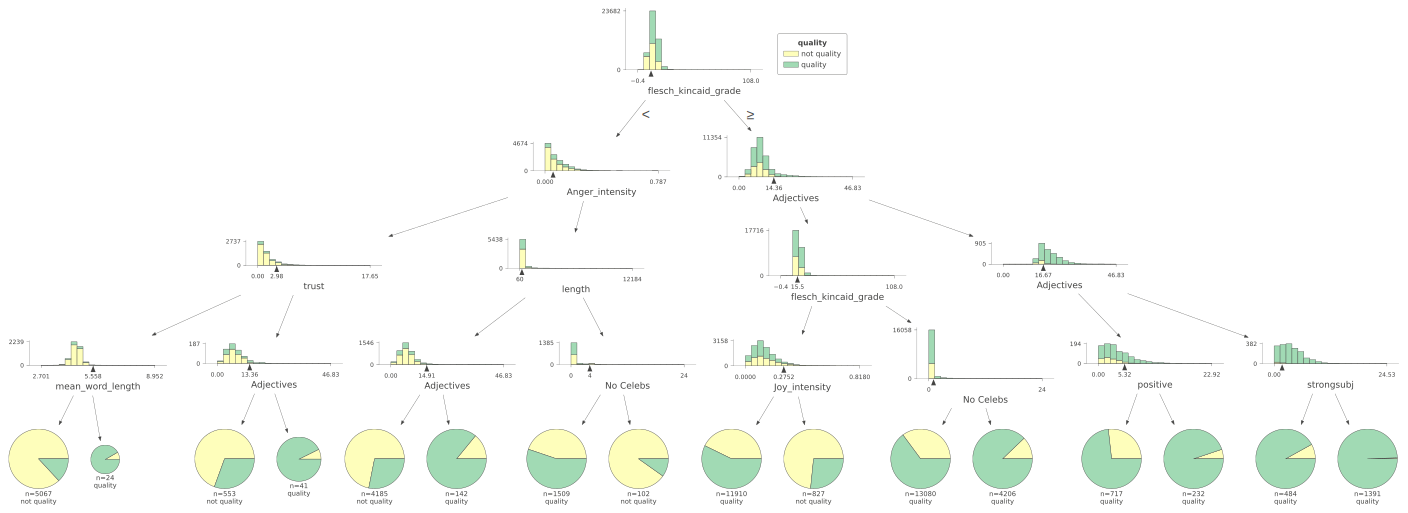

In [84]:
viz_model.view()

In [111]:
v = viz_model.view() 
v.save("XGBoosttree_ks140224.svg")

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

In [112]:
viz_model.view(orientation="LR")
v.save("XGBoosttree_LRks140224.svg")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

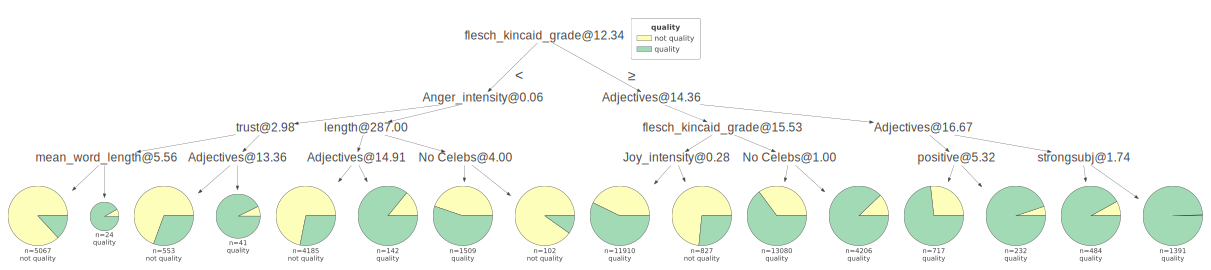

In [87]:
viz_model.view(fancy=False)

In [88]:
v = viz_model.view(fancy=False) 
v.save("XGBoosttree_NonFancy_ks140224.svg")

Another way to reduce the visualization size is to specify the tree depths of interest:

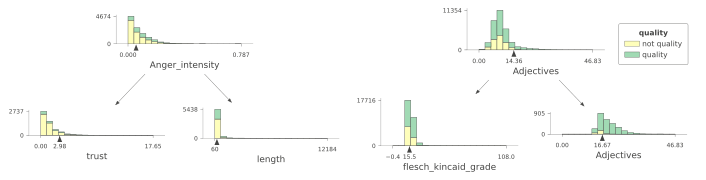

In [89]:
viz_model.view(depth_range_to_display=(1, 2, 3)) # root is level 0

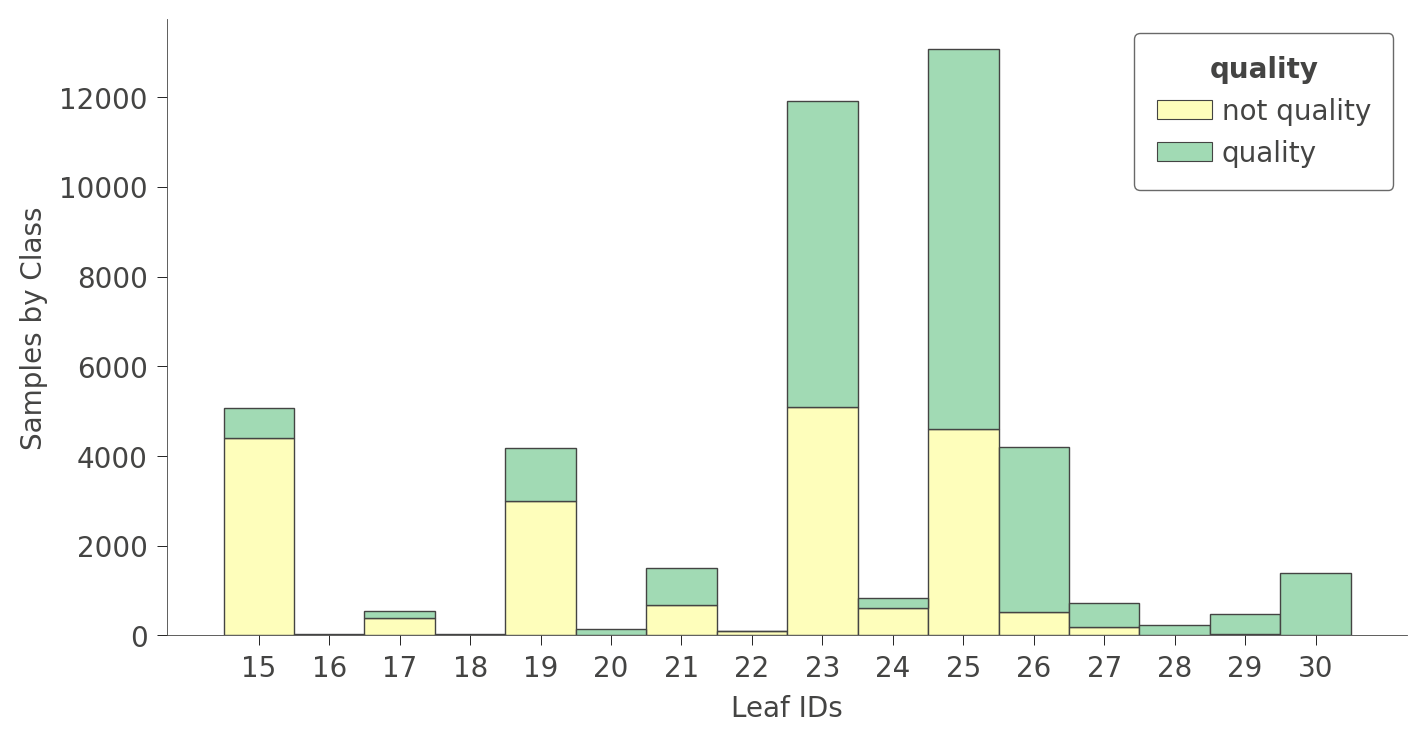

In [90]:
viz_model.ctree_leaf_distributions(figsize=(8,4))

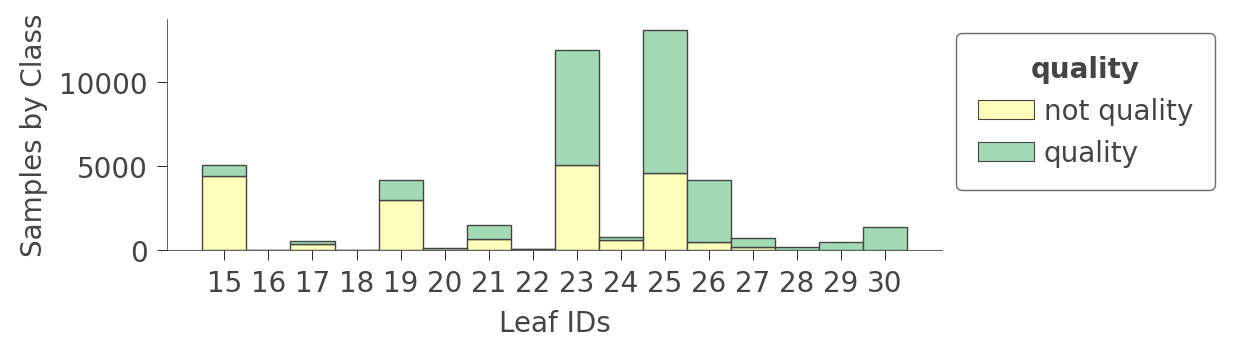

In [91]:
v = viz_model.ctree_leaf_distributions(figsize=(5,1.5))
#v.view()
#save_plt(output, 'XGBoosttree_leaf_distributions_cm110224.svg')
#v.save("XGBoosttree_leaf_distributions_cm110224.svg.svg")

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [92]:
x = dataset[features].iloc[10]
x

anger                     0.000000
anticipation              0.909091
disgust                   0.000000
negative                  0.000000
positive                  0.909091
surprise                  0.000000
trust                     0.909091
valence                   0.620875
arousal                   0.488562
dominance                 0.534023
strongsubj                0.909091
flesch_kincaid_grade     17.710014
mean_word_length          5.052632
sources                   0.000000
length                  154.000000
Adjectives                4.545455
Anger_intensity           0.223000
Joy_intensity             0.149833
Sadness_intensity         0.000000
Fear_intensity            0.273500
No Celebs                 0.000000
animal                    0.000000
crime                     0.000000
caps_body                 0.000000
Name: 10, dtype: float64

and then display the path through the tree structure:

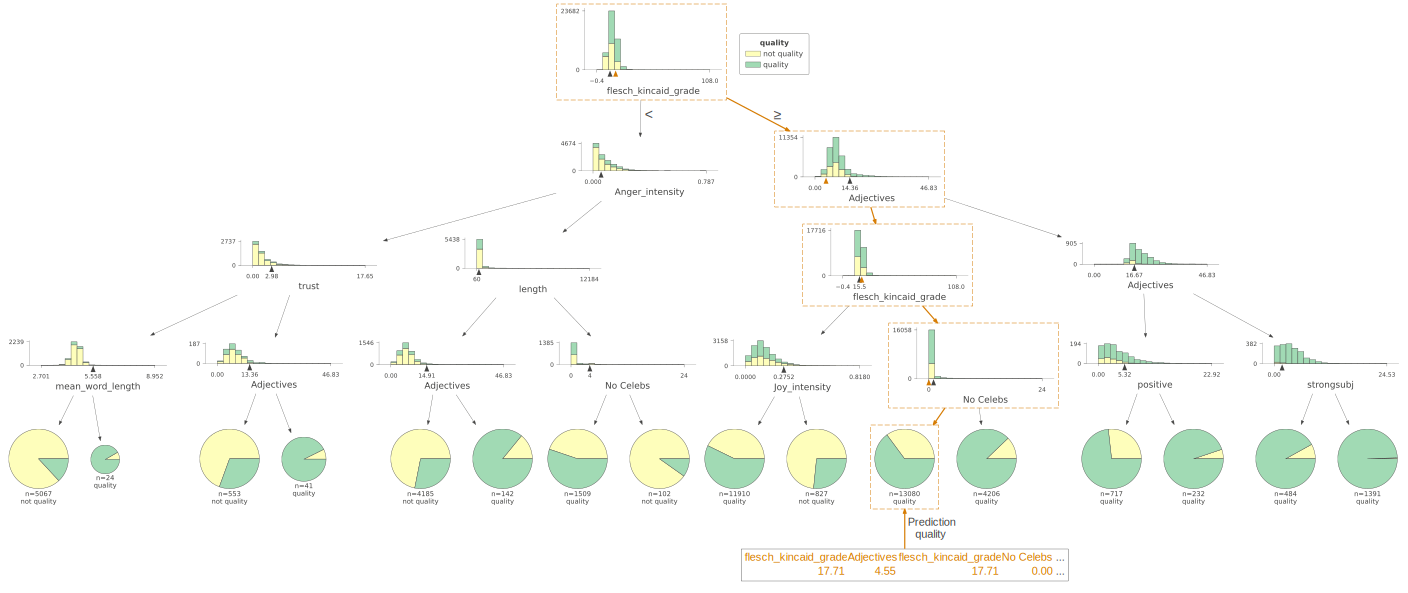

In [93]:
viz_model.view(x=x)

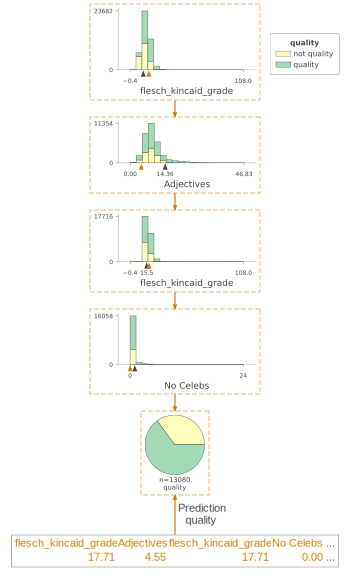

In [94]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [95]:
print(viz_model.explain_prediction_path(x))

15.53 <= flesch_kincaid_grade 
Adjectives < 14.36
No Celebs < 1.0



## Leaf info

There are a number of functions to get information about the leaves of the tree.

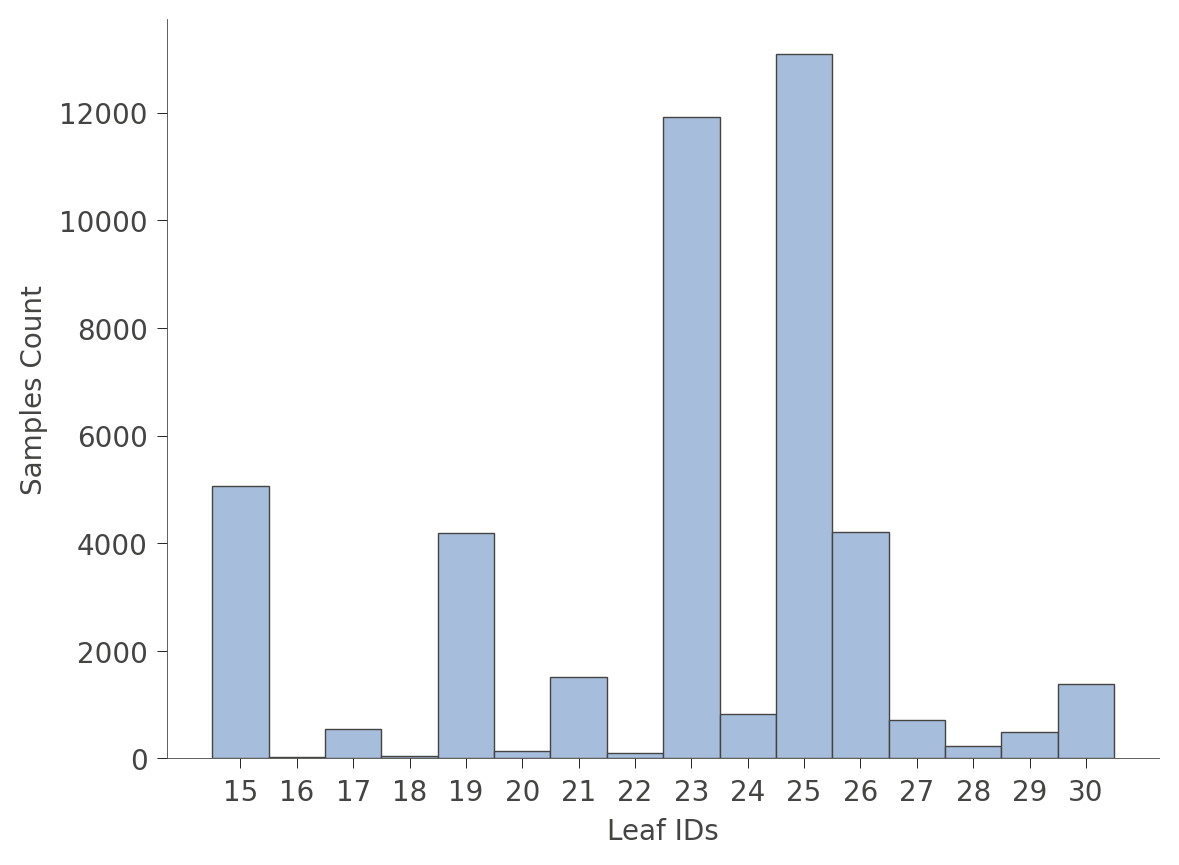

In [96]:
viz_model.leaf_sizes()

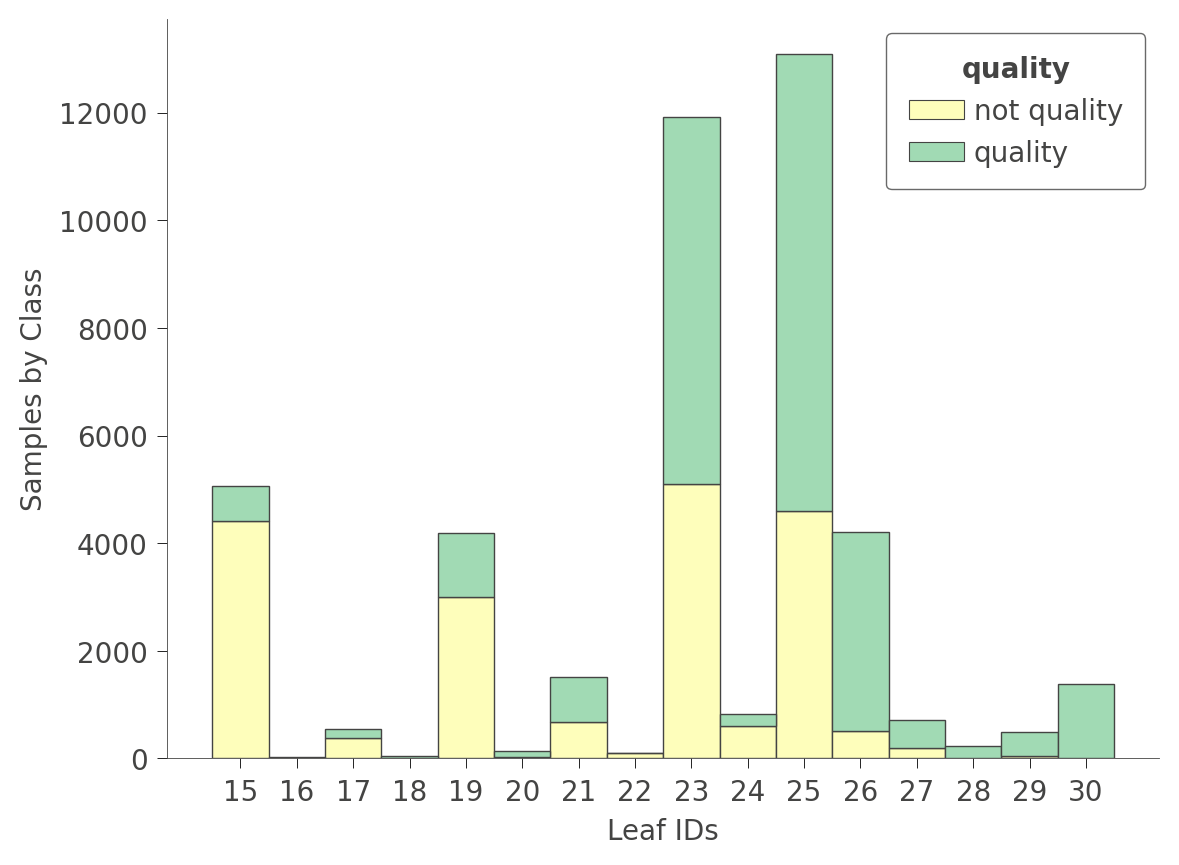

In [97]:
viz_model.ctree_leaf_distributions()

In [98]:
viz_model.node_stats(node_id=10)

,anger,anticipation,disgust,negative,positive,surprise,trust,valence,arousal,dominance,...,length,Adjectives,Anger_intensity,Joy_intensity,Sadness_intensity,Fear_intensity,No Celebs,animal,crime,caps_body
count,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,...,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0,1611.0
mean,0.954497,1.555701,0.473162,2.084484,3.020187,0.551635,1.673867,3.842045,0.463589,0.537806,...,741.816263,8.055248,0.112486,0.140654,0.118178,0.145073,0.622595,0.488516,0.543762,0.227188
std,0.832965,1.14331,0.570385,1.381506,1.527549,0.632666,1.268038,36.615567,0.103734,0.100938,...,895.769727,3.903973,0.047279,0.06991,0.057428,0.063206,1.355581,1.241752,1.399127,1.642005
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109588,0.205667,0.205459,...,287.0,1.333333,0.056407,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.389105,0.784314,0.0,1.079525,1.960784,0.0,0.706723,0.507801,0.38921,0.465817,...,372.0,5.643689,0.075046,0.088975,0.078259,0.099148,0.0,0.0,0.0,0.0
50%,0.793651,1.339286,0.357143,1.859504,2.821748,0.411523,1.488834,0.586626,0.45508,0.532308,...,527.0,6.927711,0.101083,0.135929,0.109048,0.133393,0.0,0.0,0.0,0.0
75%,1.359784,2.083333,0.691448,2.829474,3.828769,0.847458,2.371275,0.67179,0.532999,0.605061,...,778.0,8.603907,0.140077,0.185709,0.148355,0.180184,1.0,0.0,1.0,0.0
max,6.010929,12.345679,5.027933,8.849558,11.111111,5.586592,8.457711,500.418395,0.809196,0.878343,...,12184.0,32.871972,0.420286,0.476429,0.414192,0.458048,9.0,14.0,15.0,43.0


In [99]:
import eli5

In [100]:
eli5.show_weights(xgb_model, top = 12,feature_names = features)

Weight,Feature
0.2369,flesch_kincaid_grade
0.1032,No Celebs
0.0633,Adjectives
0.0612,caps_body
0.0592,Joy_intensity
0.0508,Sadness_intensity
0.0496,Anger_intensity
0.0363,trust
0.0355,crime
0.0354,length


In [49]:
#Decision Trees

In [101]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [102]:

dt_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced') # Set max_depth & class_weight 
dt_model.fit(X_train, Y_train)

Y_pred_dt = dt_model.predict(X_test)


In [103]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using DTrees is: "+str(score_dt)+" %")

The accuracy score achieved using DTrees is: 70.41 %


In [104]:
f1_score(Y_test, Y_pred_dt, average='weighted')

0.7022559274559008

In [105]:
# Visualize 
#plt.figure(figsize=(18, 22)) 
#plot_tree(dt_model, feature_names=features, class_names=['low', 'high'], filled=True, rounded=True) 
#plt.title("Decision Tree") 
#plt.show()

In [106]:
viz_model = dtreeviz.model(dt_model,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["not quality", "quality"])

In [107]:
v = viz_model.view() 
v.save("Dtree_ks140224.svg")

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [108]:
v = viz_model.view(fancy=False) 
v.save("Dtree_NonFancy_ks140224.svg")

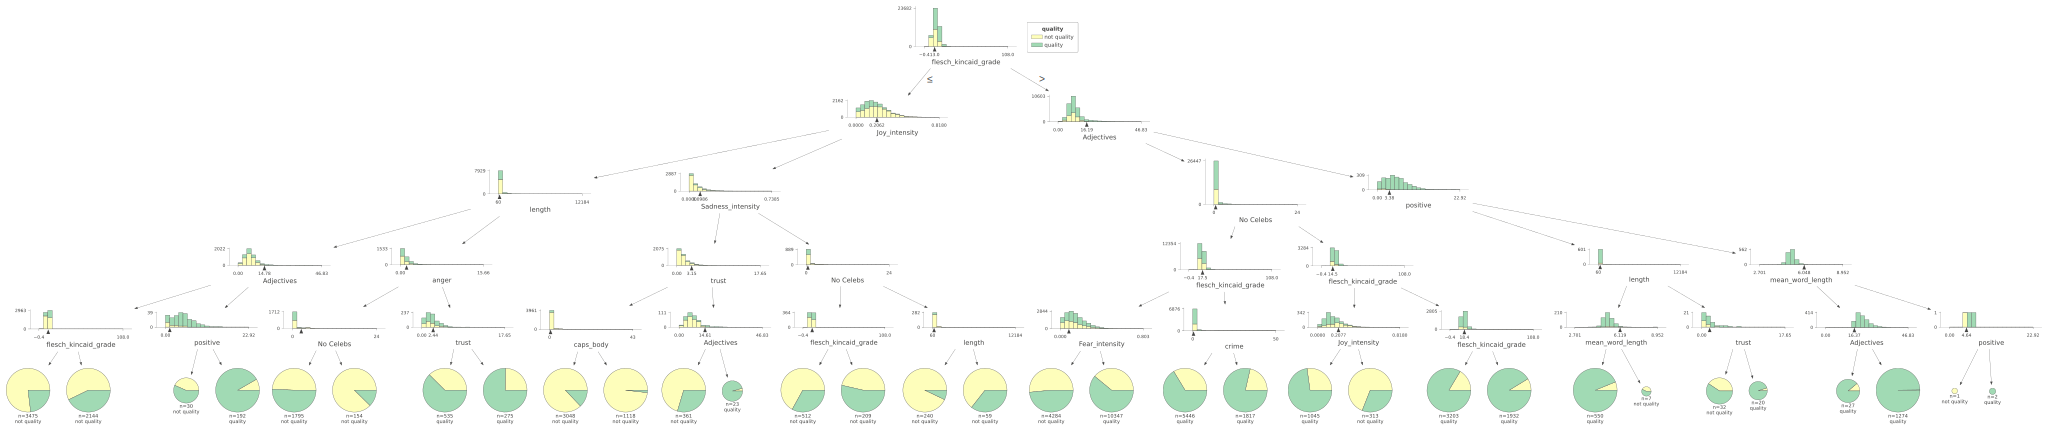

In [109]:
viz_model.view() 

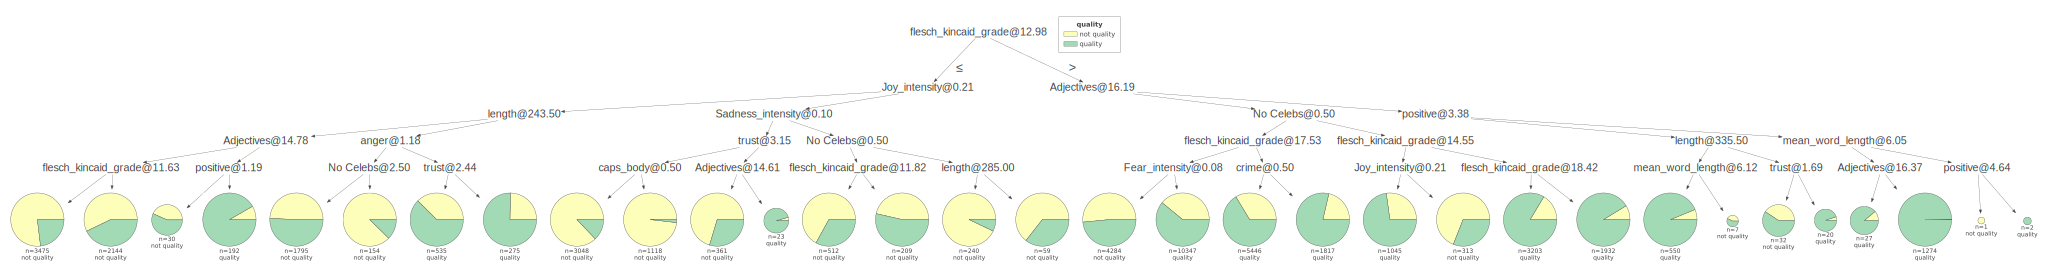

In [110]:
viz_model.view(fancy=False) 

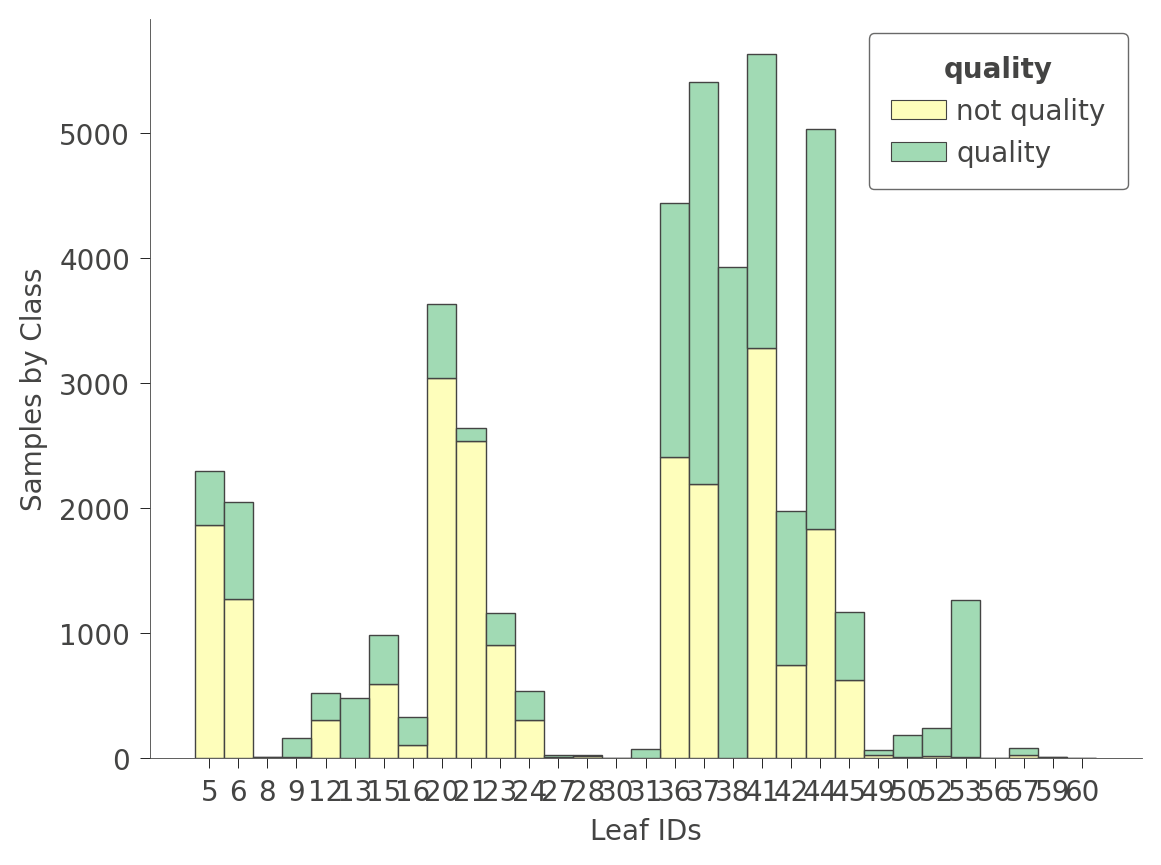

In [60]:
viz_model.ctree_leaf_distributions()